In [1]:
import nba_api
from nba_api.stats.endpoints import leaguegamefinder, teamdetails, boxscoreadvancedv2, cumestatsteam
from nba_api.stats.static import teams

from geopy import geocoders
from geopy.geocoders import Nominatim

import pandas as pd
import numpy as np

import datetime

import networkx as nx

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
def get_team_ids():
    nba_teams = teams.get_teams()
    nba_team_ids = []
    for team in nba_teams:
        nba_team_ids.append(team['id'])
        
    return nba_team_ids

In [3]:
def get_team_details():
    nba_team_ids = get_team_ids()
    
    gn = Nominatim(user_agent='cs-5483-995-nba-travel')

    nba_team_details = {}

    for nba_team_id in nba_team_ids:
        result = teamdetails.TeamDetails(team_id = nba_team_id)
        team_details = result.get_data_frames()[0][['TEAM_ID','ABBREVIATION','NICKNAME','CITY']]
    
        team_details['FULL_NAME'] = team_details['CITY'] + " " + team_details['NICKNAME']

        city_lat_long = gn.geocode(team_details['CITY'][0])
    
        team_details['LAT'] = city_lat_long.raw['lat']
        team_details['LON'] = city_lat_long.raw['lon']
    
        team_details_dict = {'ID':nba_team_id, 'NICKNAME':team_details['NICKNAME'][0], 'CITY':team_details['CITY'][0], 
                         'FULL_NAME':team_details['FULL_NAME'][0], 'LAT':team_details['LAT'][0], 'LON':team_details['LON'][0]}
    
        nba_team_details[team_details['ABBREVIATION'][0]] = team_details_dict
        
    return nba_team_details

In [4]:
def get_nba_games(season, season_type='Regular Season'):
    
    gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable=season, season_type_nullable=season_type, league_id_nullable='00')
    all_games = gamefinder.get_data_frames()[0]

    all_games = all_games.sort_values(by='GAME_ID', ascending=True)
    all_games = all_games.reset_index(drop=True)
    
    all_games['GAME_DATE'] = pd.to_datetime(all_games['GAME_DATE'])
    all_games['OPP_ABBREVIATION'] = all_games.MATCHUP.str[-3:]
    all_games['NUMBER_GAMES_PLAYED'] = [i+1 for i in all_games.index]

    all_games_opp_name = []
    all_games_home_away = []
    all_games_home_team = []
    all_games_away_team = []
    all_games_off_eff = []
    all_games_def_eff = []
    for _, row in all_games.iterrows():
        all_games_opp_name.append(nba_team_details[row['OPP_ABBREVIATION']]['FULL_NAME'])
        all_games_home_away.append('AWAY' if '@' in row['MATCHUP'] else 'HOME')
        all_games_home_team.append(row['OPP_ABBREVIATION'] if '@' in row['MATCHUP'] else row['TEAM_ABBREVIATION'])
        all_games_away_team.append(row['TEAM_ABBREVIATION'] if '@' in row['MATCHUP'] else row['OPP_ABBREVIATION'])
        all_games_off_eff.append((row['FGA'] - row['OREB'] + row['TOV'] + 0.4*row['FTA'])/row['PTS'])
        row_matchup = all_games[all_games['GAME_ID'] == row['GAME_ID']]
        opponent_details = row_matchup[row_matchup['TEAM_ABBREVIATION'] == row['OPP_ABBREVIATION']]
        #print(opponent_details['PTS'].values)
        #print(opponent_details.shape)
        all_games_def_eff.append((row['FGA'] - row['OREB'] + row['TOV'] + 0.4*row['FTA'])/opponent_details['PTS'].values[0])
    
    all_games['OPP_NAME'] = all_games_opp_name
    all_games['HOME_AWAY'] = all_games_home_away
    all_games['HOME_TEAM_ABBREVIATION'] = all_games_home_team
    all_games['AWAY_TEAM_ABBREVIATION'] = all_games_away_team
    all_games['OFF_EFF'] = all_games_off_eff
    all_games['DEF_EFF'] = all_games_def_eff
    
    NUMBER_GAMES_PLAYEDs_for_teams = [0] * all_games.shape[0]
        
    for team_id in get_team_ids():
        rows_with_team_id = all_games.index[all_games['TEAM_ID'] == team_id].tolist()
        num_games_played = 1
        #print(f'BEFORE team_id: {team_id}, num_games_played: {num_games_played}\n')
        for row_num in rows_with_team_id:
            NUMBER_GAMES_PLAYEDs_for_teams[row_num] = num_games_played
            num_games_played += 1
            
        #print(f'AFTER team_id: {team_id}, num_games_played: {num_games_played}')
      
    all_games['NUMBER_GAMES_PLAYED'] = NUMBER_GAMES_PLAYEDs_for_teams

    return all_games

In [21]:
def add_advanced_stats_to_df(games_df):
    game_ids = list(set(games_df["GAME_ID"].to_list()))
    
    i = 1
    first_game_id = game_ids[0]
    print(f'game_id: {first_game_id}, i: {i}')
    boxscoreadvancedfinder = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id=first_game_id)
    advanced_stats = boxscoreadvancedfinder.get_data_frames()[1]
    advanced_stats = advanced_stats[['GAME_ID', 'TEAM_ID', 'E_OFF_RATING', 'E_DEF_RATING', 'E_NET_RATING']]
    
    i += 1
    
    for game_id in game_ids[1:]:
        print(f'game_id: {game_id}, i: {i}')
        boxscoreadvancedfinder = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id=first_game_id)
        advanced_stats_for_game = boxscoreadvancedfinder.get_data_frames()[1]
        advanced_stats_to_keep = advanced_stats_for_game[['GAME_ID', 'TEAM_ID', 'E_OFF_RATING', 'E_DEF_RATING', 'E_NET_RATING']]
        
        advanced_stats = pd.concat([advanced_stats, advanced_stats_to_keep])
        
        i += 1

    games_df.merge(advanced_stats, on=['GAME_ID', 'TEAM_ID'])
    
    return games_df

In [6]:
def get_team_lat_lon(team_details):
    team_cities_lat_lon = {}
    for key, value in team_details.items():
        team_cities_lat_lon[key] = (float(value['LON']), float(value['LAT']))
    
    return team_cities_lat_lon

In [27]:
def get_edges_for_team(team_abbreviation, games):
    
    edge_pairs = []
    unique_edge_pairs = []
    unique_edge_pairs_with_weights = []
    edges = []

    games_for_team = games[games['TEAM_ABBREVIATION'] == team_abbreviation]
    games_for_team = games_for_team.reset_index(drop=True)
    only_home_teams = games_for_team['HOME_TEAM_ABBREVIATION'].tolist()
    
    for i in range(0,len(only_home_teams)-1):    
        if only_home_teams[i] != team_abbreviation or only_home_teams[i+1] != team_abbreviation:
            edges.append((only_home_teams[i], only_home_teams[i+1]))
            
            edge_pair = only_home_teams[i] + "->" + only_home_teams[i+1]
            
            if edge_pair not in unique_edge_pairs:
                unique_edge_pairs.append(edge_pair)
        
                edge_pair_with_weights = []
                edge_pair_with_weights.append(edge_pair)
                edge_pair_with_weights.append('')
                edge_pair_with_weights.append([{"NUMBER_GAMES_PLAYED": games_for_team.at[i, "NUMBER_GAMES_PLAYED"], 
                                                "OFF_EFF": games_for_team.at[i, "OFF_EFF"]*100,
                                               "DEF_EFF": games_for_team.at[i, "DEF_EFF"]*100,
                                               #"E_OFF_RATING": games_for_team.at[i, "E_OFF_RATING"],
                                               #"E_DEF_RATING": games_for_team.at[i, "E_DEF_RATING"]
                                               }])
                edge_pair_with_weights.append(1)
                unique_edge_pairs_with_weights.append(edge_pair_with_weights)
                
            else:
                index = next((idx for idx, val in enumerate(unique_edge_pairs_with_weights) if edge_pair in val), None)
        
                unique_edge_pairs_with_weights[index][2].append({"NUMBER_GAMES_PLAYED": games_for_team.at[i, "NUMBER_GAMES_PLAYED"], "OFF_EFF": games_for_team.at[i, "OFF_EFF"]*100,
                                                                "DEF_EFF": games_for_team.at[i, "DEF_EFF"]*100, 
                                                                 #"E_OFF_RATING": games_for_team.at[i, "E_OFF_RATING"], "E_DEF_RATING": games_for_team.at[i, "E_DEF_RATING"]
                                                                })
        
                unique_edge_pairs_with_weights[index][3] += 1
            
    unique_edge_pairs_list = []
    for unique_edge_pair in unique_edge_pairs:
        unique_edge_pairs_list.append(unique_edge_pair.split('->'))
            
    return unique_edge_pairs_list, unique_edge_pairs_with_weights

In [8]:
def convert_edge_weights(edge_list, weight_value):
    weighted_edge_list = []
    for edge_pair in edge_list:
        edge_teams = edge_pair[0].split('->')
        if len(edge_pair[2]) > 1:
            weight_sum = 0
            for weight_dict in edge_pair[2]:
                weight_sum += weight_dict[weight_value]
                
            edge_teams.append({"weight": weight_sum/len(edge_pair[2])})
            
        else:
            edge_teams.append({"weight": edge_pair[2][0][weight_value]})
            
        weighted_edge_list.append(edge_teams)
        
    return weighted_edge_list

In [9]:
def draw_network_graph(G, teams_to_modify_pos, team_pos_offset, team_abbreviation=None, node_color='#1f78b4', 
                       node_size=250, font_color='#000000', font_size=8, width=0.5, alpha=None):
    # Map projection
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(1, 1, figsize=(20, 20), subplot_kw=dict(projection=crs))
    color_map = make_nba_team_color_map()
    
    pos_dict = get_team_lat_lon(get_team_details())
    for team in teams_to_modify_pos:
        lat_lon_pair = list(pos_dict[team])
        lat_lon_pair[0] += team_pos_offset
        lat_lon_pair[1] += team_pos_offset
        pos_dict[team] = tuple(lat_lon_pair)

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)
    
    # Extent of continental US.
    ax.set_extent([-128, -62, 20, 50])
    
    if isinstance(G, dict):
        for key in G:
            nx.draw_networkx(G[key], ax=ax, font_size=font_size, width=width, node_size=node_size, pos=pos_dict, node_color=node_color, 
                             edge_color=color_map[key], font_color=font_color, alpha=alpha)
            
        plt.savefig(f'nba_travel_graph_all_teams.png', format="PNG", dpi=250)
    else:
        nx.draw_networkx(G, ax=ax, font_size=font_size, width=width, node_size=node_size, pos=pos_dict, node_color=node_color, 
                             edge_color=color_map[team_abbreviation], font_color=font_color, alpha=alpha)
        plt.savefig(f'nba_travel_graph_{team_abbreviation}.png', format="PNG", dpi=250)

In [10]:
def draw_network_graph_new(G, teams_to_modify_pos, team_pos_offset, team_abbreviation=None, node_color='#1f78b4', 
                       node_size=250, font_color='#000000', font_size=8, width=0.5, alpha=None):
    # Map projection
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(1, 1, figsize=(20, 20), subplot_kw=dict(projection=crs))
    color_map = make_nba_team_color_map()
    
    pos_dict = get_team_lat_lon(get_team_details())
    for team in teams_to_modify_pos:
        lat_lon_pair = list(pos_dict[team])
        lat_lon_pair[0] += team_pos_offset
        lat_lon_pair[1] += team_pos_offset
        pos_dict[team] = tuple(lat_lon_pair)

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)
    
    # Extent of continental US.
    ax.set_extent([-128, -62, 20, 50])
    
    if isinstance(G, dict):
        for key in G:
            nx.draw_networkx_nodes(G[key], ax=ax, pos=pos_dict, node_size=node_size, node_color=node_color)
            nx.draw_networkx_labels(G[key], ax=ax, pos=pos_dict, font_size=font_size, font_color=font_color)
            for edge in G.edges(data=True):
                nx.draw_networkx_edges(G[key], ax=ax, pos=pos_dict, edgelist=[(edge[0],edge[1])], node_size=node_size, label=edge[2]['weight'],
                                      width=width, alpha=alpha, edge_color=color_map[key])
                
            plt.savefig(f'nba_travel_graph_all_teams.png', format="PNG", dpi=250)
            #nx.draw_networkx(G[key], ax=ax, font_size=font_size, width=width, node_size=node_size, pos=pos_dict, node_color=node_color, 
                             #edge_color=color_map[key], font_color=font_color, alpha=alpha)
    else:
        nx.draw_networkx_nodes(G, ax=ax, pos=pos_dict, node_size=node_size, node_color=node_color)
        nx.draw_networkx_labels(G, ax=ax, pos=pos_dict, font_size=font_size, font_color=font_color)
        for edge in G.edges(data=True):
                nx.draw_networkx_edges(G, ax=ax, pos=pos_dict, edgelist=[(edge[0],edge[1])], node_size=node_size, label=edge[2]['weight'],
                                      width=width, alpha=alpha, edge_color=color_map[team_abbreviation])
                
        plt.savefig(f'nba_travel_graph_{team_abbreviation}.png', format="PNG", dpi=250)
        #nx.draw_networkx(G, ax=ax, font_size=font_size, width=width, node_size=node_size, pos=pos_dict, node_color=node_color, 
                             #edge_color=color_map[team_abbreviation], font_color=font_color, alpha=alpha)

In [11]:
def make_nba_team_color_map():
    nba_team_color_map = {
        'ATL': '#C1D32F',
        'BKN': '#000000',
        'BOS': '#00A55C',
        'CLE': '#6F2633',
        'CHA': '#00788C',
        'CHI': '#9BD3DD',
        'DAL': '#0053BC',
        'DEN': '#0E2240',
        'DET': '#1D428A',
        'GSW': '#FDB927',
        'HOU': '#CE1141',
        'IND': '#002D62',
        'LAC': '#BEC0C2',
        'LAL': '#552583',
        'MEM': '#12173F',
        'MIA': '#F9A01B',
        'MIL': '#00471B',
        'MIN': '#78BE20',
        'NOP': '#B4975A',
        'NYK': '#F58426',
        'OKC': '#EF3B24',
        'ORL': '#0077C0',
        'PHI': '#002B5C',
        'PHX': '#B95915',
        'POR': '#E03A3E',
        'SAC': '#5B2B82',
        'SAS': '#C4CED4',
        'TOR': '#B4975A',
        'UTA': '#F9A01B',
        'WAS': '#E31837' }
    
    return nba_team_color_map

In [12]:
nba_team_details = get_team_details()

In [13]:
nba_team_details['OKC']

{'ID': 1610612760,
 'NICKNAME': 'Thunder',
 'CITY': 'Oklahoma City',
 'FULL_NAME': 'Oklahoma City Thunder',
 'LAT': '35.4729886',
 'LON': '-97.5170536'}

In [15]:
games_2016_17 = get_nba_games(season='2016-17', season_type='Regular Season')
games_2016_17.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,OPP_ABBREVIATION,NUMBER_GAMES_PLAYED,OPP_NAME,HOME_AWAY,HOME_TEAM_ABBREVIATION,AWAY_TEAM_ABBREVIATION,OFF_EFF,DEF_EFF
0,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,W,241,117,45,94,0.479,13,35,0.371,14,19,0.737,11,40,51,31,12,5,14,22,29.0,NYK,1,New York Knicks,HOME,CLE,NYK,0.894017,1.188636
1,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,L,240,88,32,87,0.368,9,27,0.333,15,20,0.750,13,29,42,17,6,6,18,22,-29.0,CLE,1,Cleveland Cavaliers,AWAY,CLE,NYK,1.136364,0.854701
2,22016,1610612762,UTA,Utah Jazz,0021600002,2016-10-25,UTA @ POR,L,241,104,40,82,0.488,8,24,0.333,16,16,1.000,6,25,31,19,9,5,11,19,-9.0,POR,1,Portland Trail Blazers,AWAY,POR,UTA,0.898077,0.826549
3,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,W,239,113,39,75,0.520,13,19,0.684,22,22,1.000,5,29,34,22,5,3,12,18,9.0,UTA,1,Utah Jazz,HOME,POR,UTA,0.803540,0.873077
4,22016,1610612744,GSW,Golden State Warriors,0021600003,2016-10-25,GSW vs. SAS,L,241,100,40,85,0.471,7,33,0.212,13,18,0.722,8,27,35,24,11,6,16,19,-29.0,SAS,1,San Antonio Spurs,HOME,GSW,SAS,1.002000,0.776744


In [16]:
games_2016_17.shape

(2460, 36)

In [26]:
games_2016_17.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS',
       'OPP_ABBREVIATION', 'NUMBER_GAMES_PLAYED', 'OPP_NAME', 'HOME_AWAY',
       'HOME_TEAM_ABBREVIATION', 'AWAY_TEAM_ABBREVIATION', 'OFF_EFF',
       'DEF_EFF'],
      dtype='object')

In [22]:
games_2016_17_adv = add_advanced_stats_to_df(games_2016_17)

game_id: 0021600185, i: 1
game_id: 0021600847, i: 2
game_id: 0021600665, i: 3
game_id: 0021601085, i: 4
game_id: 0021600028, i: 5
game_id: 0021601096, i: 6
game_id: 0021600609, i: 7
game_id: 0021600289, i: 8
game_id: 0021600758, i: 9
game_id: 0021600752, i: 10
game_id: 0021600468, i: 11
game_id: 0021601212, i: 12
game_id: 0021600903, i: 13
game_id: 0021600542, i: 14
game_id: 0021600871, i: 15
game_id: 0021600909, i: 16
game_id: 0021601216, i: 17
game_id: 0021600775, i: 18
game_id: 0021600239, i: 19
game_id: 0021600261, i: 20
game_id: 0021600544, i: 21
game_id: 0021600897, i: 22
game_id: 0021600573, i: 23
game_id: 0021600057, i: 24
game_id: 0021600910, i: 25
game_id: 0021600068, i: 26
game_id: 0021601189, i: 27
game_id: 0021600552, i: 28
game_id: 0021600809, i: 29
game_id: 0021600724, i: 30
game_id: 0021600898, i: 31
game_id: 0021600836, i: 32
game_id: 0021600519, i: 33
game_id: 0021600175, i: 34
game_id: 0021600662, i: 35
game_id: 0021600399, i: 36
game_id: 0021600335, i: 37
game_id: 0

In [23]:
nba_team_lat_lon = get_team_lat_lon(nba_team_details)

In [28]:
edges = {}
unique_edge_pairs_with_weights = {}

for key in nba_team_details:
    edges[key], unique_edge_pairs_with_weights[key] = get_edges_for_team(key, games_2016_17)

In [29]:
#unique_edge_pairs_with_weights['OKC']

[['PHI->OKC',
  '',
  [{'NUMBER_GAMES_PLAYED': 1,
    'OFF_EFF': 98.44660194174757,
    'DEF_EFF': 104.53608247422682}],
  1],
 ['OKC->LAC',
  '',
  [{'NUMBER_GAMES_PLAYED': 3,
    'OFF_EFF': 98.05309734513274,
    'DEF_EFF': 115.41666666666666}],
  1],
 ['LAC->GSW',
  '',
  [{'NUMBER_GAMES_PLAYED': 4,
    'OFF_EFF': 121.17647058823529,
    'DEF_EFF': 124.09638554216869},
   {'NUMBER_GAMES_PLAYED': 43,
    'OFF_EFF': 100.61224489795917,
    'DEF_EFF': 82.16666666666667}],
  2],
 ['GSW->OKC',
  '',
  [{'NUMBER_GAMES_PLAYED': 5,
    'OFF_EFF': 105.41666666666667,
    'DEF_EFF': 82.95081967213115}],
  1],
 ['OKC->DET',
  '',
  [{'NUMBER_GAMES_PLAYED': 10,
    'OFF_EFF': 85.81196581196582,
    'DEF_EFF': 84.36974789915966}],
  1],
 ['DET->OKC',
  '',
  [{'NUMBER_GAMES_PLAYED': 11,
    'OFF_EFF': 112.27272727272728,
    'DEF_EFF': 95.0}],
  1],
 ['OKC->LAL',
  '',
  [{'NUMBER_GAMES_PLAYED': 14,
    'OFF_EFF': 101.98198198198199,
    'DEF_EFF': 98.43478260869566}],
  1],
 ['LAL->SAC',
  '',


In [30]:
single_weighted_edges_off_eff = {}
for key in nba_team_details:
    single_weighted_edges_off_eff[key] = convert_edge_weights(unique_edge_pairs_with_weights[key], "OFF_EFF")

In [31]:
#single_weighted_edges_off_eff['OKC']

[['PHI', 'OKC', {'weight': 98.44660194174757}],
 ['OKC', 'LAC', {'weight': 98.05309734513274}],
 ['LAC', 'GSW', {'weight': 110.89435774309723}],
 ['GSW', 'OKC', {'weight': 105.41666666666667}],
 ['OKC', 'DET', {'weight': 85.81196581196582}],
 ['DET', 'OKC', {'weight': 112.27272727272728}],
 ['OKC', 'LAL', {'weight': 101.98198198198199}],
 ['LAL', 'SAC', {'weight': 92.11009174311927}],
 ['SAC', 'DEN', {'weight': 94.25742574257427}],
 ['DEN', 'OKC', {'weight': 85.3030303030303}],
 ['OKC', 'NYK', {'weight': 88.11320754716981}],
 ['NYK', 'OKC', {'weight': 85.89285714285715}],
 ['OKC', 'ATL', {'weight': 102.37623762376238}],
 ['ATL', 'OKC', {'weight': 100.19607843137254}],
 ['OKC', 'POR', {'weight': 88.61087943656752}],
 ['POR', 'UTA', {'weight': 108.63157894736844}],
 ['UTA', 'OKC', {'weight': 99.7752808988764}],
 ['OKC', 'NOP', {'weight': 87.4074074074074}],
 ['NOP', 'BOS', {'weight': 78.18181818181817}],
 ['BOS', 'OKC', {'weight': 83.24786324786325}],
 ['OKC', 'MIA', {'weight': 87.142857

In [32]:
networks_2016_17_digraphs = {}

for key in nba_team_details:
    networks_2016_17_digraphs[key] = nx.DiGraph(single_weighted_edges_off_eff[key])
    #print(f'Team Abbrev: {key}, # Nodes: {len(networks_2016_17[key].nodes())}, # Edges: {len(networks_2016_17[key].edges())}\n')

In [33]:
# On the networkx plot/visualization, the nodes BKN/NYK and LAC/LAL are almost completely overlapping
# One of the nodes is offset so they can both be seen in the diagram but will not be offset when used in distance calculations
# Team to offset was chosen in alphabetical order
teams_to_modify_pos = ['BKN', 'LAC']
offset_value = 1

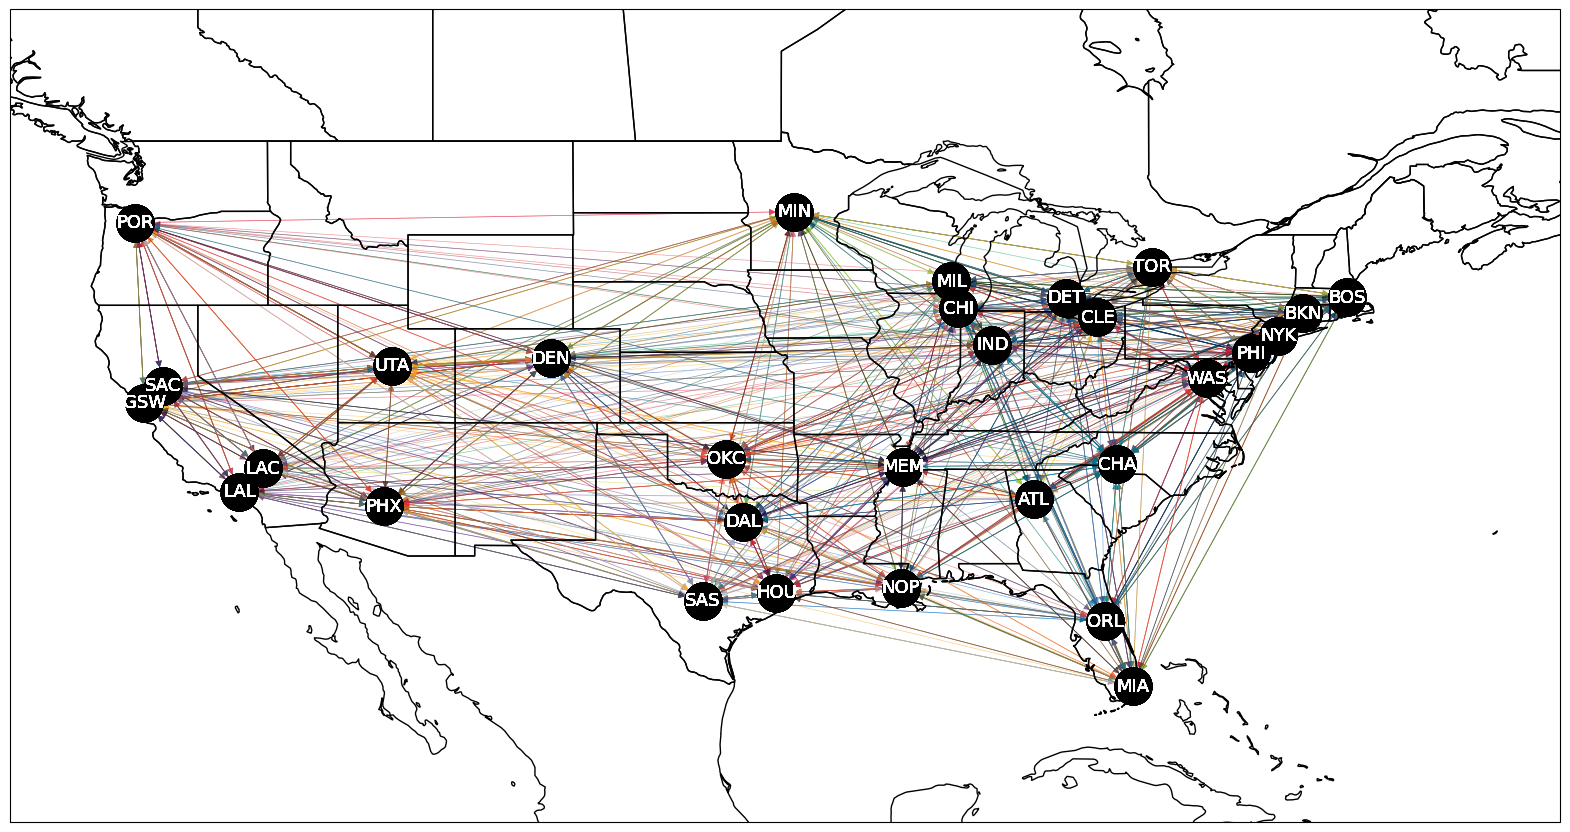

In [34]:
draw_network_graph(G=networks_2016_17_digraphs, teams_to_modify_pos=teams_to_modify_pos, team_pos_offset=1,
                   node_color='#000000', node_size=700, font_color='#FFFFFF', font_size=13, alpha=0.5)

In [35]:
network_2016_17_okc_digraph = networks_2016_17_digraphs['OKC']

In [36]:
network_2016_17_okc_digraph.edges()

OutEdgeView([('PHI', 'OKC'), ('OKC', 'LAC'), ('OKC', 'DET'), ('OKC', 'LAL'), ('OKC', 'NYK'), ('OKC', 'ATL'), ('OKC', 'POR'), ('OKC', 'NOP'), ('OKC', 'MIA'), ('OKC', 'MIL'), ('OKC', 'CHI'), ('OKC', 'MIN'), ('OKC', 'CLE'), ('OKC', 'IND'), ('OKC', 'WAS'), ('OKC', 'BKN'), ('OKC', 'HOU'), ('OKC', 'MEM'), ('LAC', 'GSW'), ('GSW', 'OKC'), ('GSW', 'UTA'), ('DET', 'OKC'), ('LAL', 'SAC'), ('SAC', 'DEN'), ('SAC', 'LAC'), ('DEN', 'OKC'), ('DEN', 'MIN'), ('NYK', 'OKC'), ('ATL', 'OKC'), ('POR', 'UTA'), ('POR', 'PHX'), ('UTA', 'OKC'), ('UTA', 'NOP'), ('NOP', 'BOS'), ('NOP', 'OKC'), ('BOS', 'OKC'), ('MIA', 'MEM'), ('MEM', 'OKC'), ('MEM', 'PHX'), ('MIL', 'CHA'), ('CHA', 'HOU'), ('HOU', 'OKC'), ('HOU', 'DAL'), ('CHI', 'OKC'), ('MIN', 'SAC'), ('MIN', 'OKC'), ('CLE', 'SAS'), ('SAS', 'OKC'), ('IND', 'OKC'), ('WAS', 'OKC'), ('PHX', 'DAL'), ('PHX', 'DEN'), ('DAL', 'OKC'), ('DAL', 'ORL'), ('BKN', 'TOR'), ('TOR', 'OKC'), ('ORL', 'OKC')])

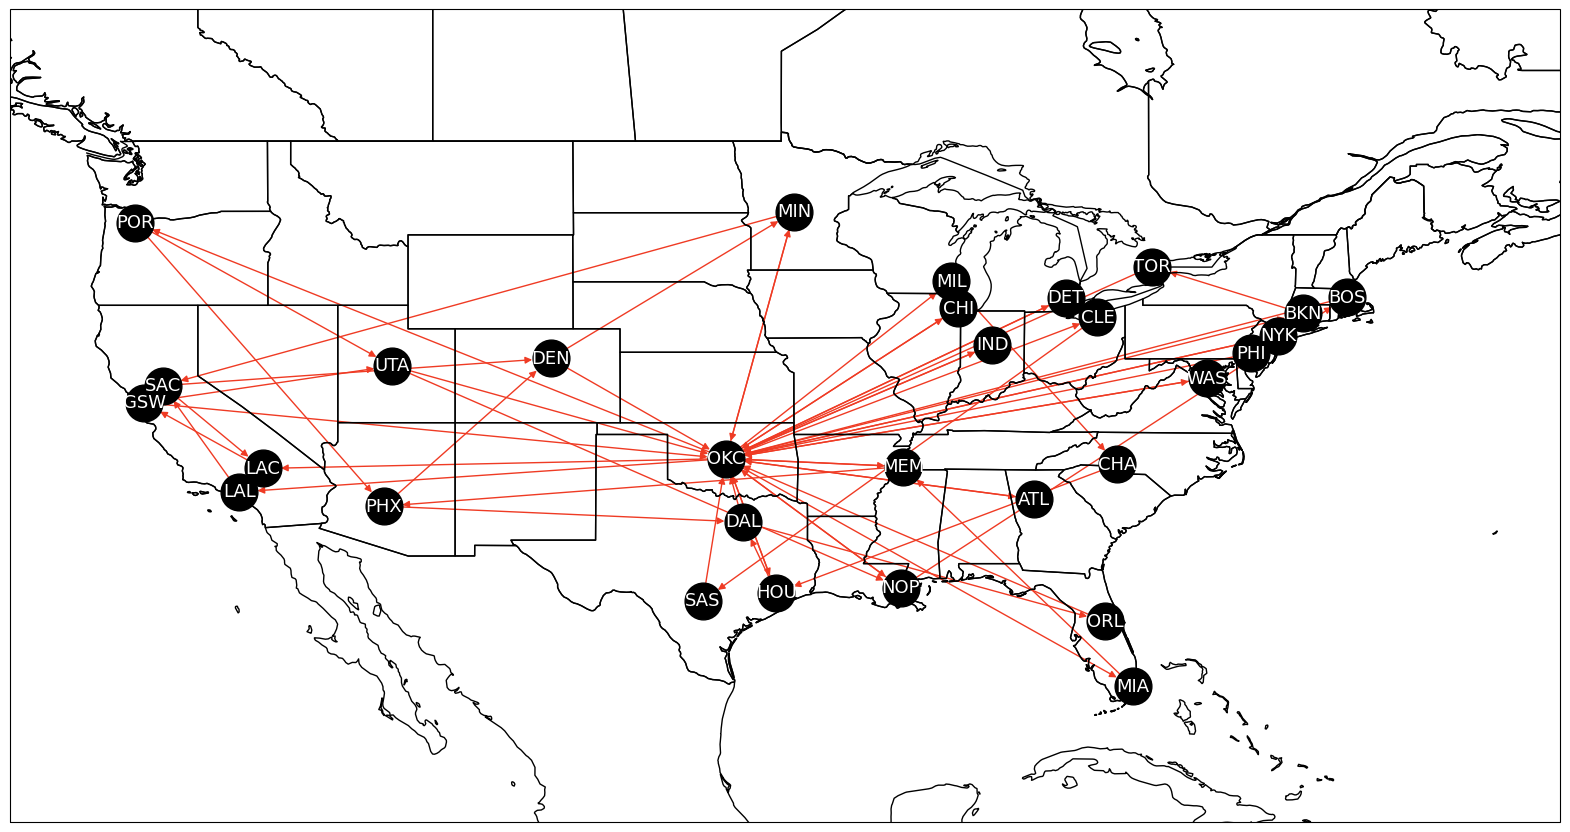

In [37]:
draw_network_graph_new(network_2016_17_okc_digraph, teams_to_modify_pos=teams_to_modify_pos, team_abbreviation='OKC', team_pos_offset=1,
                   node_color='#000000', node_size=700, font_color='#FFFFFF', font_size=13, width=1)

In [38]:
games_2016_17_okc = games_2016_17[games_2016_17['TEAM_ABBREVIATION'] == 'OKC']
games_2016_17_okc = games_2016_17_okc.reset_index(drop=True)
games_2016_17_okc['GAME_ID'] = games_2016_17_okc['GAME_ID'].astype(str)
games_2016_17_okc.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,OPP_ABBREVIATION,NUMBER_GAMES_PLAYED,OPP_NAME,HOME_AWAY,HOME_TEAM_ABBREVIATION,AWAY_TEAM_ABBREVIATION,OFF_EFF,DEF_EFF
0,22016,1610612760,OKC,Oklahoma City Thunder,0021600011,2016-10-26,OKC @ PHI,W,240,103,39,94,0.415,6,22,0.273,19,26,0.731,13,40,53,19,7,3,10,23,4.0,PHI,1,Philadelphia 76ers,AWAY,PHI,OKC,0.984466,1.045361
1,22016,1610612760,OKC,Oklahoma City Thunder,0021600021,2016-10-28,OKC vs. PHX,W,264,113,40,96,0.417,5,21,0.238,28,38,0.737,14,43,57,13,11,3,22,24,3.0,PHX,2,Phoenix Suns,HOME,OKC,PHX,1.054867,1.083636
2,22016,1610612760,OKC,Oklahoma City Thunder,0021600040,2016-10-30,OKC vs. LAL,W,241,113,45,95,0.474,9,26,0.346,14,17,0.824,10,35,45,29,15,6,19,22,17.0,LAL,3,Los Angeles Lakers,HOME,OKC,LAL,0.980531,1.154167
3,22016,1610612760,OKC,Oklahoma City Thunder,0021600064,2016-11-02,OKC @ LAC,W,242,85,34,84,0.405,5,20,0.250,12,20,0.600,10,42,52,14,8,4,21,24,2.0,LAC,4,Los Angeles Clippers,AWAY,LAC,OKC,1.211765,1.240964
4,22016,1610612760,OKC,Oklahoma City Thunder,0021600069,2016-11-03,OKC @ GSW,L,239,96,35,87,0.402,10,27,0.370,16,28,0.571,13,28,41,20,8,6,16,20,-26.0,GSW,5,Golden State Warriors,AWAY,GSW,OKC,1.054167,0.829508


In [53]:
#unique_edge_pairs_with_weights_okc = unique_edge_pairs_with_weights['OKC']

unique_edge_pairs_list_dict = {}

for key in unique_edge_pairs_with_weights:

    unique_edge_pairs_list = []

    for edge_pair in unique_edge_pairs_with_weights[key]:
        edge_pair_list = []
        for edge_stats in edge_pair[2]:
            edge_pair_list = [edge_pair[0], edge_stats['NUMBER_GAMES_PLAYED'], edge_stats['OFF_EFF'], edge_stats['DEF_EFF']]
            unique_edge_pairs_list.append(edge_pair_list)
            edge_pair_list = []
        
    unique_edge_pairs_list_sorted = sorted(unique_edge_pairs_list, key=lambda x:x[1])
    
    unique_edge_pairs_list_dict[key] = unique_edge_pairs_list_sorted
    
#unique_edge_pairs_list_dict['PHI']

In [55]:
for j in range(1, games_ahead+1):
    print(j)

1
2


In [81]:
games_ahead = 2
weight = 'OFF_EFF'
consecutive_paths_of_games_ahead_len_dict = {}
consecutive_paths_of_games_ahead_len_list = []

for key in unique_edge_pairs_list_dict:
    
    consecutive_paths_of_games_ahead_len = []
    
    len_edge_pairs_list = len(unique_edge_pairs_list_dict[key])
    for i, edge_pair in enumerate(unique_edge_pairs_list_dict[key]):
        # check if number games played is consecutive (i.e. 3->4->5) with no gaps
        cur_games_played = edge_pair[1]
        
        consecutive_games_played = True
        for j in range(1, games_ahead+1):
            if i+j < len_edge_pairs_list:
                if unique_edge_pairs_list_dict[key][i+j][1] != cur_games_played+j:
                    consecutive_games_played=False
                    break
            else:
                consecutive_games_played=False
                break
                      
        if consecutive_games_played:
            #game_paths_len_games_ahead = [] 
            total_off_eff = 0
            total_def_eff = 0
            path_string = ""
            for j in range(i, i+games_ahead+1):
                # get all values except num_games_player, then convert 
                # team abbrev to one string value and average out off_eff and def_eff
                total_off_eff += unique_edge_pairs_list_dict[key][j][2]
                total_def_eff += unique_edge_pairs_list_dict[key][j][3]
                path_string_len = len(unique_edge_pairs_list_dict[key][j][0])
                path_string += unique_edge_pairs_list_dict[key][j][0][:path_string_len-3]
                #game_paths_len_games_ahead.append(unique_edge_pairs_list_dict[key][j])
                
            avg_off_eff = total_off_eff / (games_ahead+1)
            avg_def_eff = total_def_eff / (games_ahead+1)
            # adds all nodes in path to path_string
            #path_string += unique_edge_pairs_list_dict[key][i+games_ahead][0][-3:]
            # adds only starting nodes to path string, removes final arrow
            path_string = path_string[:len(path_string)-2]
            
                
            game_paths_len_games_ahead = [path_string, avg_off_eff, avg_def_eff]
                
            consecutive_paths_of_games_ahead_len.append(game_paths_len_games_ahead)
            consecutive_paths_of_games_ahead_len_list.append(game_paths_len_games_ahead)
            
    consecutive_paths_of_games_ahead_len_dict[key] = consecutive_paths_of_games_ahead_len
    
#print(consecutive_paths_of_games_ahead_len_dict['OKC'][0])
len(consecutive_paths_of_games_ahead_len_list)

1082

In [83]:
totals = {}
for edge_path in consecutive_paths_of_games_ahead_len_list:
    if edge_path[0] in totals:
        totals[edge_path[0]] += 1
    else:
        totals[edge_path[0]] = 1
        
num_distinct_paths = 0
for k, v in totals.items():    
    if v > 1:
        print(f'{k}, {v}')
        num_distinct_paths += 1
        
num_distinct_paths

BOS->NYK->BOS, 2
SAC->POR->UTA, 2
POR->SAC->GSW, 2
LAC->LAL->DEN, 2
BKN->CHI->IND, 2
NOP->MIN->SAC, 2
POR->UTA->LAC, 2
MEM->CHI->ATL, 2
SAC->GSW->PHX, 2
DAL->LAL->GSW, 2
UTA->DEN->PHX, 2
MEM->MIN->NOP, 2
HOU->ORL->MIA, 2
GSW->MEM->OKC, 2
NYK->ATL->WAS, 2
HOU->MIN->HOU, 2
POR->GSW->PHX, 2
SAC->NOP->MIN, 2
BKN->PHI->CLE, 2
POR->UTA->LAL, 2
LAC->LAL->SAS, 2
SAC->LAL->LAC, 2
LAL->LAC->GSW, 2
LAC->LAL->GSW, 2
SAC->UTA->SAS, 2
DEN->GSW->SAC, 2
PHX->GSW->DEN, 2
MIL->IND->NYK, 2
SAS->MEM->PHI, 2
MEM->PHI->DET, 2
ORL->CHA->ORL, 2
BOS->TOR->MIN, 2
IND->MIL->IND, 2
IND->NYK->IND, 2
CHI->MIL->MEM, 2
POR->PHX->DAL, 2
DAL->SAC->UTA, 2
SAS->DAL->SAS, 2
UTA->POR->GSW, 2
UTA->SAC->UTA, 2
CHA->NYK->CHA, 2


41

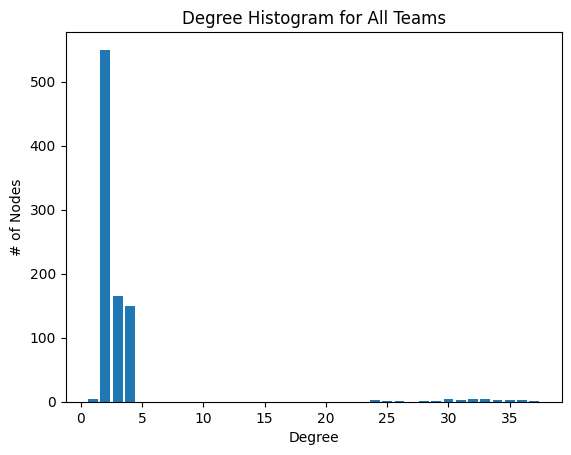

In [123]:
degree_sequence_all_teams = []

for key in nba_team_details:
    degree_sequence_team = sorted((d for n, d in networks_2016_17_digraphs[key].degree()), reverse=True)
    degree_sequence_all_teams += degree_sequence_team

fig, ax = plt.subplots()
ax.bar(*np.unique(degree_sequence_all_teams, return_counts=True))
ax.set_title("Degree Histogram for All Teams")
ax.set_xlabel("Degree")
ax.set_ylabel("# of Nodes")
plt.show()

df_all_teams_freq = pd.Series(degree_sequence_all_teams).value_counts().sort_index().reset_index().reset_index(drop=True)
df_all_teams_freq.columns = ['Element', 'Frequency']
#df_all_teams_freq

In [39]:
network_2016_17_okc_digraph.degree()

DiDegreeView({'PHI': 1, 'OKC': 36, 'LAC': 3, 'GSW': 3, 'DET': 2, 'LAL': 2, 'SAC': 4, 'DEN': 4, 'NYK': 2, 'ATL': 2, 'POR': 3, 'UTA': 4, 'NOP': 4, 'BOS': 2, 'MIA': 2, 'MEM': 4, 'MIL': 2, 'CHA': 2, 'HOU': 4, 'CHI': 2, 'MIN': 4, 'CLE': 2, 'SAS': 2, 'IND': 2, 'WAS': 2, 'PHX': 4, 'DAL': 4, 'BKN': 2, 'TOR': 2, 'ORL': 2})

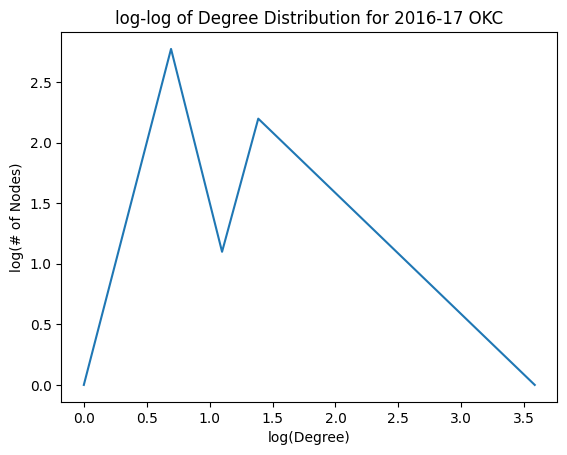

In [129]:
import math
log_degree_sequence = sorted((math.log(d, math.e) for n, d in network_2016_17_okc_digraph.degree()), reverse=True)

unique_log_values = sorted(list(set(log_degree_sequence)))
unique_log_values_count = []
for item in unique_log_values:
    unique_log_values_count.append(math.log(log_degree_sequence.count(item), math.e))

fig, ax = plt.subplots()
ax.plot(unique_log_values, unique_log_values_count)
ax.set_title("log-log of Degree Distribution for 2016-17 OKC")
ax.set_xlabel("log(Degree)")
ax.set_ylabel("log(# of Nodes)")
plt.show()

### Degree Distribution for 2016-17 OKC

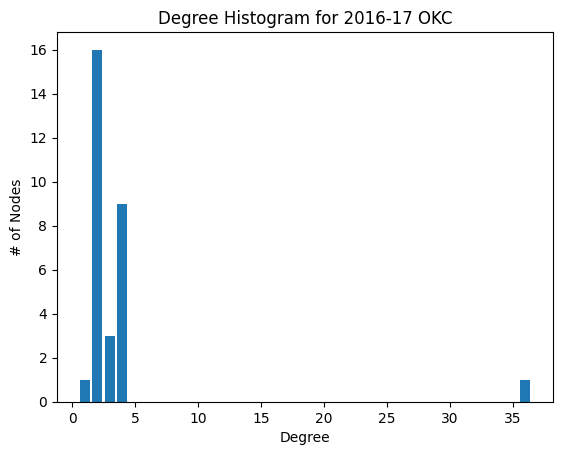

In [126]:
degree_sequence = sorted((d for n, d in network_2016_17_okc_digraph.degree()), reverse=True)
dmax = max(degree_sequence)

fig, ax = plt.subplots()
ax.bar(*np.unique(degree_sequence, return_counts=True))
ax.set_title("Degree Histogram for 2016-17 OKC")
ax.set_xlabel("Degree")
ax.set_ylabel("# of Nodes")
plt.show()

### Laplacian Matrices

In [62]:
nx.directed_combinatorial_laplacian_matrix(network_2016_17_okc_digraph)

<class 'networkx.utils.decorators.argmap'> compilation 9:5: FutureWarning: directed_combinatorial_laplacian_matrix will return a numpy array instead of a matrix in NetworkX 3.0


matrix([[ 1.66388889e-03, -1.05068601e-03, -3.38950176e-05,
         -3.36586001e-05, -1.64728025e-05, -1.90534306e-05,
         -3.49448788e-05, -2.87133192e-05, -1.68400655e-05,
         -1.91163512e-05, -1.69194907e-05, -2.59413344e-05,
         -2.82814699e-05, -1.44352348e-05, -1.66852040e-05,
         -3.12374297e-05, -1.57972406e-05, -1.64657119e-05,
         -2.99205586e-05, -1.65740350e-05, -3.14542401e-05,
         -1.67458620e-05, -1.73669023e-05, -1.86155243e-05,
         -1.73931748e-05, -2.19890911e-05, -2.66376482e-05,
         -1.64002157e-05, -1.70385383e-05, -1.46095103e-05],
        [-1.05068601e-03,  3.08641280e-01, -9.67931379e-03,
         -9.61129879e-03, -1.70875599e-02, -1.00406867e-02,
         -2.91186441e-04, -7.72758569e-03, -1.75176249e-02,
         -2.01831555e-02, -8.75818878e-03, -7.34464957e-03,
         -1.69886080e-02, -7.70709396e-03, -8.61738248e-03,
         -1.81578966e-02, -8.08371650e-03, -2.72707274e-04,
         -1.59517089e-02, -1.72061032e-

### All Pairs Dijkstra's Shortest Path

In [44]:
paths_len_3_to_5 = []

for n, (dist, path) in nx.all_pairs_dijkstra(network_2016_17_okc_digraph):
    print(path)

{'PHI': ['PHI'], 'OKC': ['PHI', 'OKC'], 'LAC': ['PHI', 'OKC', 'LAC'], 'DET': ['PHI', 'OKC', 'DET'], 'LAL': ['PHI', 'OKC', 'LAL'], 'NYK': ['PHI', 'OKC', 'NYK'], 'ATL': ['PHI', 'OKC', 'ATL'], 'POR': ['PHI', 'OKC', 'POR'], 'NOP': ['PHI', 'OKC', 'NOP'], 'MIA': ['PHI', 'OKC', 'MIA'], 'MIL': ['PHI', 'OKC', 'MIL'], 'CHI': ['PHI', 'OKC', 'CHI'], 'MIN': ['PHI', 'OKC', 'MIN'], 'CLE': ['PHI', 'OKC', 'CLE'], 'IND': ['PHI', 'OKC', 'IND'], 'WAS': ['PHI', 'OKC', 'WAS'], 'BKN': ['PHI', 'OKC', 'BKN'], 'HOU': ['PHI', 'OKC', 'HOU'], 'MEM': ['PHI', 'OKC', 'MEM'], 'DAL': ['PHI', 'OKC', 'HOU', 'DAL'], 'CHA': ['PHI', 'OKC', 'MIL', 'CHA'], 'TOR': ['PHI', 'OKC', 'BKN', 'TOR'], 'PHX': ['PHI', 'OKC', 'MEM', 'PHX'], 'BOS': ['PHI', 'OKC', 'NOP', 'BOS'], 'SAS': ['PHI', 'OKC', 'CLE', 'SAS'], 'UTA': ['PHI', 'OKC', 'POR', 'UTA'], 'SAC': ['PHI', 'OKC', 'LAL', 'SAC'], 'GSW': ['PHI', 'OKC', 'LAC', 'GSW'], 'ORL': ['PHI', 'OKC', 'HOU', 'DAL', 'ORL'], 'DEN': ['PHI', 'OKC', 'MEM', 'PHX', 'DEN']}
{'OKC': ['OKC'], 'LAC': ['OKC

In [80]:
# All pairs shortest path
dict(nx.all_pairs_shortest_path(network_2016_17_okc_digraph))

{'PHI': {'PHI': ['PHI'],
  'OKC': ['PHI', 'OKC'],
  'LAC': ['PHI', 'OKC', 'LAC'],
  'DET': ['PHI', 'OKC', 'DET'],
  'LAL': ['PHI', 'OKC', 'LAL'],
  'NYK': ['PHI', 'OKC', 'NYK'],
  'ATL': ['PHI', 'OKC', 'ATL'],
  'POR': ['PHI', 'OKC', 'POR'],
  'NOP': ['PHI', 'OKC', 'NOP'],
  'MIA': ['PHI', 'OKC', 'MIA'],
  'MIL': ['PHI', 'OKC', 'MIL'],
  'CHI': ['PHI', 'OKC', 'CHI'],
  'MIN': ['PHI', 'OKC', 'MIN'],
  'CLE': ['PHI', 'OKC', 'CLE'],
  'IND': ['PHI', 'OKC', 'IND'],
  'WAS': ['PHI', 'OKC', 'WAS'],
  'BKN': ['PHI', 'OKC', 'BKN'],
  'HOU': ['PHI', 'OKC', 'HOU'],
  'MEM': ['PHI', 'OKC', 'MEM'],
  'GSW': ['PHI', 'OKC', 'LAC', 'GSW'],
  'SAC': ['PHI', 'OKC', 'LAL', 'SAC'],
  'UTA': ['PHI', 'OKC', 'POR', 'UTA'],
  'PHX': ['PHI', 'OKC', 'POR', 'PHX'],
  'BOS': ['PHI', 'OKC', 'NOP', 'BOS'],
  'CHA': ['PHI', 'OKC', 'MIL', 'CHA'],
  'SAS': ['PHI', 'OKC', 'CLE', 'SAS'],
  'TOR': ['PHI', 'OKC', 'BKN', 'TOR'],
  'DAL': ['PHI', 'OKC', 'HOU', 'DAL'],
  'DEN': ['PHI', 'OKC', 'LAL', 'SAC', 'DEN'],
  'ORL': 

In [68]:
nx.dag_longest_path(network_2016_17_okc_digraph)

NetworkXUnfeasible: Graph contains a cycle or graph changed during iteration

In [79]:
nx.johnson(network_2016_17_digraph, weight="weight")

{'PHI': {'PHI': ['PHI'],
  'OKC': ['PHI', 'OKC'],
  'LAC': ['PHI', 'OKC', 'LAC'],
  'DET': ['PHI', 'OKC', 'DET'],
  'LAL': ['PHI', 'OKC', 'LAL'],
  'NYK': ['PHI', 'OKC', 'NYK'],
  'ATL': ['PHI', 'OKC', 'ATL'],
  'POR': ['PHI', 'OKC', 'POR'],
  'NOP': ['PHI', 'OKC', 'NOP'],
  'MIA': ['PHI', 'OKC', 'MIA'],
  'MIL': ['PHI', 'OKC', 'MIL'],
  'CHI': ['PHI', 'OKC', 'CHI'],
  'MIN': ['PHI', 'OKC', 'MIN'],
  'CLE': ['PHI', 'OKC', 'CLE'],
  'IND': ['PHI', 'OKC', 'IND'],
  'WAS': ['PHI', 'OKC', 'WAS'],
  'BKN': ['PHI', 'OKC', 'BKN'],
  'HOU': ['PHI', 'OKC', 'HOU'],
  'MEM': ['PHI', 'OKC', 'MEM'],
  'DAL': ['PHI', 'OKC', 'HOU', 'DAL'],
  'CHA': ['PHI', 'OKC', 'MIL', 'CHA'],
  'TOR': ['PHI', 'OKC', 'BKN', 'TOR'],
  'PHX': ['PHI', 'OKC', 'MEM', 'PHX'],
  'BOS': ['PHI', 'OKC', 'NOP', 'BOS'],
  'SAS': ['PHI', 'OKC', 'CLE', 'SAS'],
  'UTA': ['PHI', 'OKC', 'POR', 'UTA'],
  'SAC': ['PHI', 'OKC', 'LAL', 'SAC'],
  'GSW': ['PHI', 'OKC', 'LAC', 'GSW'],
  'ORL': ['PHI', 'OKC', 'HOU', 'DAL', 'ORL'],
  'DEN': 

In [29]:
cumestatsteamfinder = cumestatsteam.CumeStatsTeam(game_ids=['0021600011'], season='2016-17', season_type_all_star='Regular Season', 
                                                  league_id='00', team_id='1610612760')
cumestatsteamfinder.get_data_frames()[1]

,CITY,NICKNAME,TEAM_ID,W,L,W_HOME,L_HOME,W_ROAD,L_ROAD,TEAM_TURNOVERS,TEAM_REBOUNDS,GP,GS,ACTUAL_MINUTES,ACTUAL_SECONDS,FG,FGA,FG_PCT,FG3,FG3A,FG3_PCT,FT,FTA,FT_PCT,OFF_REB,DEF_REB,TOT_REB,AST,PF,STL,TOTAL_TURNOVERS,BLK,PTS,AVG_REB,AVG_PTS,DQ


In [90]:
advanced_stats_all_games = pd.DataFrame() 
for game_id in games_2016_17_okc['GAME_ID']:
    boxscoreadvancedfinder = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id=game_id)
    advanced_stats = boxscoreadvancedfinder.get_data_frames()[1]
    advanced_stats_okc = advanced_stats.loc[advanced_stats['TEAM_ABBREVIATION'] == 'OKC']
    advanced_stats_okc = advanced_stats_okc.drop(['TEAM_ID', 'TEAM_NAME', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'MIN'], axis=1)
    advanced_stats_okc['GAME_ID'] = advanced_stats_okc['GAME_ID'].astype(str)
    
    #advanced_stats_all_games.concat(advanced_stats_okc)
    games_2016_17_okc = games_2016_17_okc.merge(advanced_stats_okc, on='GAME_ID')

KeyboardInterrupt: 

In [93]:
games_2016_17_okc.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,OPP_ABBREVIATION,NUMBER_GAMES_PLAYED,OPP_NAME,HOME_AWAY,HOME_TEAM_ABBREVIATION,AWAY_TEAM_ABBREVIATION,OFF_EFF,DEF_EFF
0,22016,1610612760,OKC,Oklahoma City Thunder,0021600011,2016-10-26,OKC @ PHI,W,240,103,39,94,0.415,6,22,0.273,19,26,0.731,13,40,53,19,7,3,10,23,4.0,PHI,1,Philadelphia 76ers,AWAY,PHI,OKC,0.984466,1.045361
1,22016,1610612760,OKC,Oklahoma City Thunder,0021600021,2016-10-28,OKC vs. PHX,W,264,113,40,96,0.417,5,21,0.238,28,38,0.737,14,43,57,13,11,3,22,24,3.0,PHX,2,Phoenix Suns,HOME,OKC,PHX,1.054867,1.083636
2,22016,1610612760,OKC,Oklahoma City Thunder,0021600040,2016-10-30,OKC vs. LAL,W,241,113,45,95,0.474,9,26,0.346,14,17,0.824,10,35,45,29,15,6,19,22,17.0,LAL,3,Los Angeles Lakers,HOME,OKC,LAL,0.980531,1.154167
3,22016,1610612760,OKC,Oklahoma City Thunder,0021600064,2016-11-02,OKC @ LAC,W,242,85,34,84,0.405,5,20,0.250,12,20,0.600,10,42,52,14,8,4,21,24,2.0,LAC,4,Los Angeles Clippers,AWAY,LAC,OKC,1.211765,1.240964
4,22016,1610612760,OKC,Oklahoma City Thunder,0021600069,2016-11-03,OKC @ GSW,L,239,96,35,87,0.402,10,27,0.370,16,28,0.571,13,28,41,20,8,6,16,20,-26.0,GSW,5,Golden State Warriors,AWAY,GSW,OKC,1.054167,0.829508


In [110]:
boxscoreadvancedfinder = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id='0021600011')
advanced_team_stats = boxscoreadvancedfinder.get_data_frames()[1]
advanced_stats_to_keep = advanced_team_stats[['GAME_ID', 'TEAM_ID', 'E_OFF_RATING', 'E_DEF_RATING', 'E_NET_RATING']]

game_for_id = games_2016_17[games_2016_17['GAME_ID'] == '0021600011']
game_for_id.merge(advanced_stats_to_keep, on=['GAME_ID', 'TEAM_ID'])

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,OPP_ABBREVIATION,NUMBER_GAMES_PLAYED,OPP_NAME,HOME_AWAY,HOME_TEAM_ABBREVIATION,AWAY_TEAM_ABBREVIATION,OFF_EFF,DEF_EFF,E_OFF_RATING,E_DEF_RATING,E_NET_RATING
0,22016,1610612755,PHI,Philadelphia 76ers,0021600011,2016-10-26,PHI vs. OKC,L,240,97,36,84,0.429,7,24,0.292,18,25,0.720,5,38,43,21,5,10,13,22,-4.0,OKC,1,Oklahoma City Thunder,HOME,PHI,OKC,1.051546,0.990291,93.3,100.5,-7.3
1,22016,1610612760,OKC,Oklahoma City Thunder,0021600011,2016-10-26,OKC @ PHI,W,240,103,39,94,0.415,6,22,0.273,19,26,0.731,13,40,53,19,7,3,10,23,4.0,PHI,1,Philadelphia 76ers,AWAY,PHI,OKC,0.984466,1.045361,100.5,93.3,7.3


In [109]:
game_for_id

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,OPP_ABBREVIATION,NUMBER_GAMES_PLAYED,OPP_NAME,HOME_AWAY,HOME_TEAM_ABBREVIATION,AWAY_TEAM_ABBREVIATION,OFF_EFF,DEF_EFF
20,22016,1610612755,PHI,Philadelphia 76ers,0021600011,2016-10-26,PHI vs. OKC,L,240,97,36,84,0.429,7,24,0.292,18,25,0.720,5,38,43,21,5,10,13,22,-4.0,OKC,1,Oklahoma City Thunder,HOME,PHI,OKC,1.051546,0.990291
21,22016,1610612760,OKC,Oklahoma City Thunder,0021600011,2016-10-26,OKC @ PHI,W,240,103,39,94,0.415,6,22,0.273,19,26,0.731,13,40,53,19,7,3,10,23,4.0,PHI,1,Philadelphia 76ers,AWAY,PHI,OKC,0.984466,1.045361


In [ ]:
game_ids = list(set(games_2016_17["GAME_ID"].to_list()))
for game_id in game_ids:
    boxscoreadvancedfinder = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id=game_id)
    advanced_stats = boxscoreadvancedfinder.get_data_frames()[1]
    advanced_stats_to_keep = advanced_stats['GAME_ID', 'TEAM_ID', 'E_OFF_RATING', 'E_DEF_RATING', 'E_NET_RATING']

In [ ]:
games_2016_17_okc.dtypes

In [ ]:
advanced_stats_all_games.head()

In [61]:

        
    i += 1
    
total = 0
for unique_edge_pair in unique_edge_pairs_with_weights:
    total += unique_edge_pair[2]
    
print(total)
unique_edge_pairs_with_weights
    
#edge_pairs, len(edge_pairs)
        
       # if only_home_teams[i] != team_abbreviation or only_home_teams[i+1] != team_abbreviation:
        #    edges.append((only_home_teams[i], only_home_teams[i+1], {"NUMBER_GAMES_PLAYED": games_for_team.at[i, "NUMBER_GAMES_PLAYED"], "weight": games_for_team.at[i, "OFF_EFF"]}))

TypeError: list indices must be integers or slices, not NoneType

In [86]:
games_2016_17.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,OPP_ABBREVIATION,NUMBER_GAMES_PLAYED,OPP_NAME,HOME_AWAY,HOME_TEAM_ABBREVIATION,AWAY_TEAM_ABBREVIATION,OFF_EFF,DEF_EFF
0,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,L,240,88,32,87,0.368,9,27,0.333,15,20,0.750,13,29,42,17,6,6,18,22,-29.0,CLE,1,Cleveland Cavaliers,AWAY,CLE,NYK,1.136364,0.854701
1,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,W,241,117,45,94,0.479,13,35,0.371,14,19,0.737,11,40,51,31,12,5,14,22,29.0,NYK,1,New York Knicks,HOME,CLE,NYK,0.894017,1.188636
2,22016,1610612762,UTA,Utah Jazz,0021600002,2016-10-25,UTA @ POR,L,241,104,40,82,0.488,8,24,0.333,16,16,1.000,6,25,31,19,9,5,11,19,-9.0,POR,1,Portland Trail Blazers,AWAY,POR,UTA,0.898077,0.826549
3,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,W,239,113,39,75,0.520,13,19,0.684,22,22,1.000,5,29,34,22,5,3,12,18,9.0,UTA,1,Utah Jazz,HOME,POR,UTA,0.803540,0.873077
4,22016,1610612744,GSW,Golden State Warriors,0021600003,2016-10-25,GSW vs. SAS,L,241,100,40,85,0.471,7,33,0.212,13,18,0.722,8,27,35,24,11,6,16,19,-29.0,SAS,1,San Antonio Spurs,HOME,GSW,SAS,1.002000,0.776744
